# Сравнение алгоритмов бустинга и подбор гиперпараметров для получения лучшего качества.
Датасет https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/

### План действий

- Предобработка, визуализации
- Сравнение XGboost, CatBoost, LightGBM, AdaBoostClassifier

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['figure.figsize'] = 18, 8

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
def get_classification_metrics(y_true, y_pred):
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    score = []
    for metric in metrics:
        score.append(metric(y_true, y_pred).round(3))
    return score

### Статистики, визуализации

In [3]:
df = pd.read_csv('parkinson/parkinsons.data')

In [4]:
print(f'Размер выборки:{df.shape}')
df.sample(5)

Размер выборки:(195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
45,phon_R01_S10_4,242.852,255.034,227.911,0.00225,0.000009,0.00117,0.00139,0.00350,0.01494,...,0.02542,0.00476,25.032,0,0.431285,0.638928,-6.995820,0.102083,2.365800,0.102706
129,phon_R01_S32_2,120.078,126.632,105.667,0.00270,0.000020,0.00116,0.00135,0.00349,0.01022,...,0.01428,0.00487,26.369,1,0.491345,0.718839,-5.892061,0.195976,2.108873,0.183572
115,phon_R01_S27_1,151.872,492.892,69.085,0.00856,0.000060,0.00404,0.00385,0.01211,0.01843,...,0.02389,0.06051,23.693,1,0.407701,0.662668,-4.673241,0.261549,2.702355,0.274407
172,phon_R01_S43_2,110.739,113.597,100.139,0.00356,0.000030,0.00170,0.00200,0.00510,0.01484,...,0.02261,0.00430,26.550,0,0.369090,0.776158,-6.085567,0.192375,1.889002,0.174152
105,phon_R01_S25_3,149.689,160.368,133.608,0.00257,0.000020,0.00116,0.00134,0.00349,0.01346,...,0.01979,0.00578,27.421,1,0.365488,0.719974,-6.997403,0.210279,1.994387,0.112878


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

In [6]:
df = df.drop('name', axis=1)

In [7]:
columns = df.columns
columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [8]:
df[columns[:12]].describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400


In [9]:
df[columns[12:]].describe()

,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


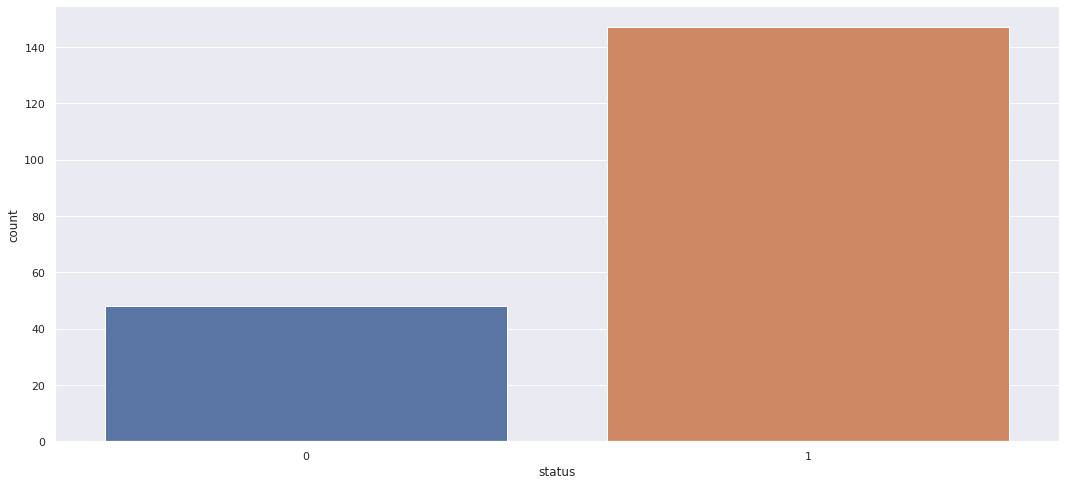

In [10]:
sns.countplot(df.status);

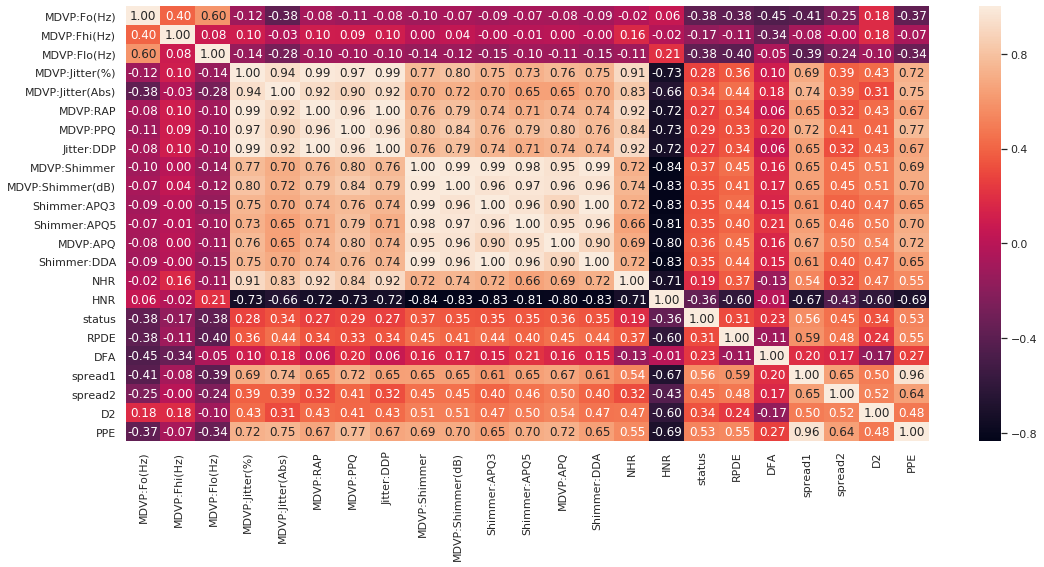

In [11]:
sns.heatmap(df.corr(), annot=True, fmt='0.2f');

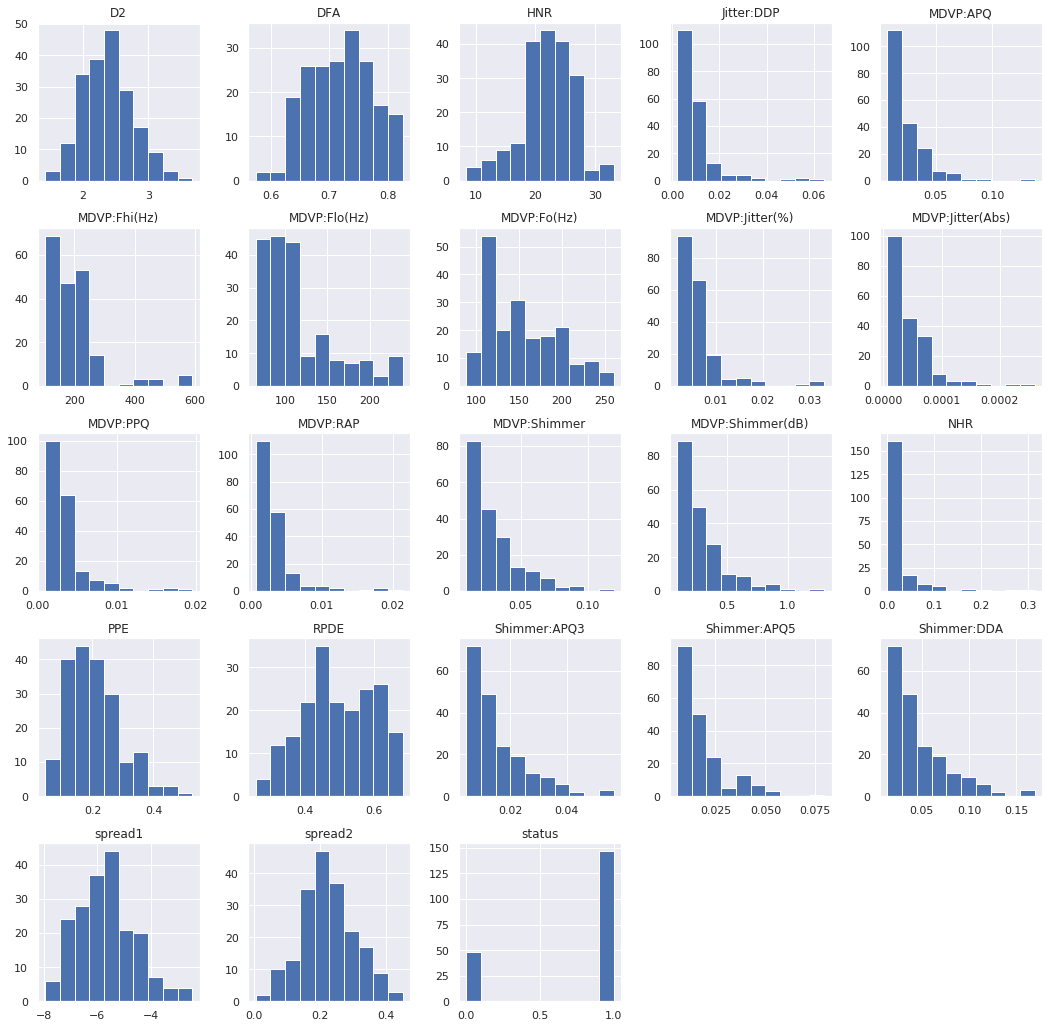

In [12]:
df.hist(figsize=(18, 18));

In [10]:
X = df.drop('status', axis=1)
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### XGBoost

In [11]:
model = XGBClassifier()
param_grid = {
    'learning_rate': [0.1, 0.16, 0.2],
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.monotonic()
grid_search.fit(X_train, y_train)
total_time = round((time.monotonic() - start_time), 2)
predict = grid_search.predict(X_test)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')
    
columns = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'Roc_auc', 'Time, sec']
index = ['XGBoost']

quality = pd.DataFrame([get_classification_metrics(y_test, predict) + [total_time]], columns=columns, index=index)
quality

Best params:
===
learning_rate: 0.2
max_depth: 3
n_estimators: 50


,Accuracy,Precision,Recall,F1 score,Roc_auc,"Time, sec"
XGBoost,0.864,0.909,0.909,0.909,0.821,2.79


#### Важность признаков

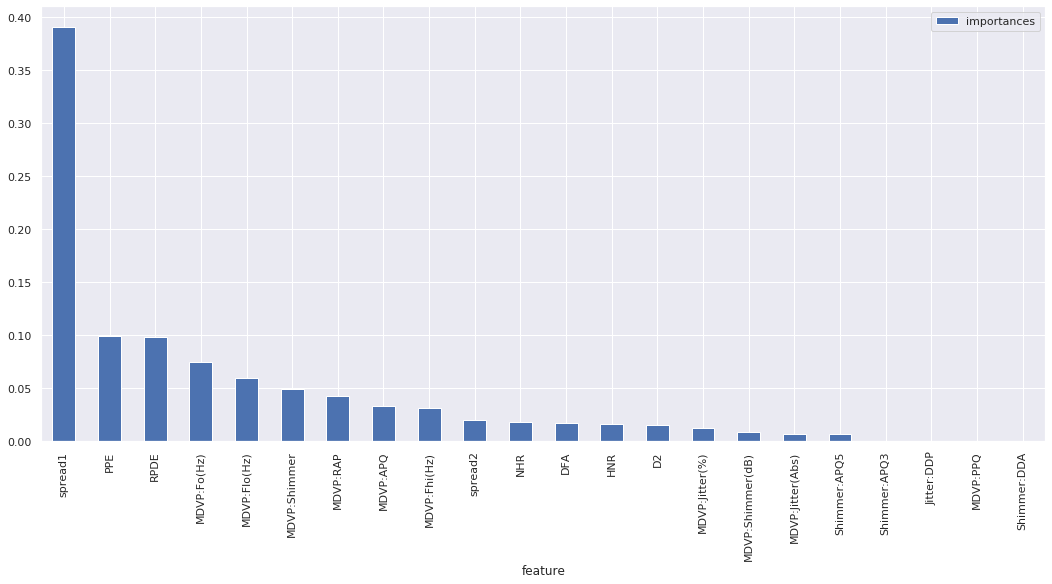

In [12]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('status', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### LightGBM

In [13]:
model = LGBMClassifier()
param_grid = {
    'learning_rate': [0.1, 0.16, 0.2],
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.monotonic()
grid_search.fit(X_train, y_train)
total_time = round((time.monotonic() - start_time), 2)
predict = grid_search.predict(X_test)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')
    
quality.loc['LightGBM', :] = get_classification_metrics(y_test, predict) + [total_time]
quality

Best params:
===
learning_rate: 0.2
max_depth: 1
n_estimators: 50


,Accuracy,Precision,Recall,F1 score,Roc_auc,"Time, sec"
XGBoost,0.864,0.909,0.909,0.909,0.821,2.79
LightGBM,0.864,0.846,1.000,0.917,0.733,1.23


#### Важность признаков

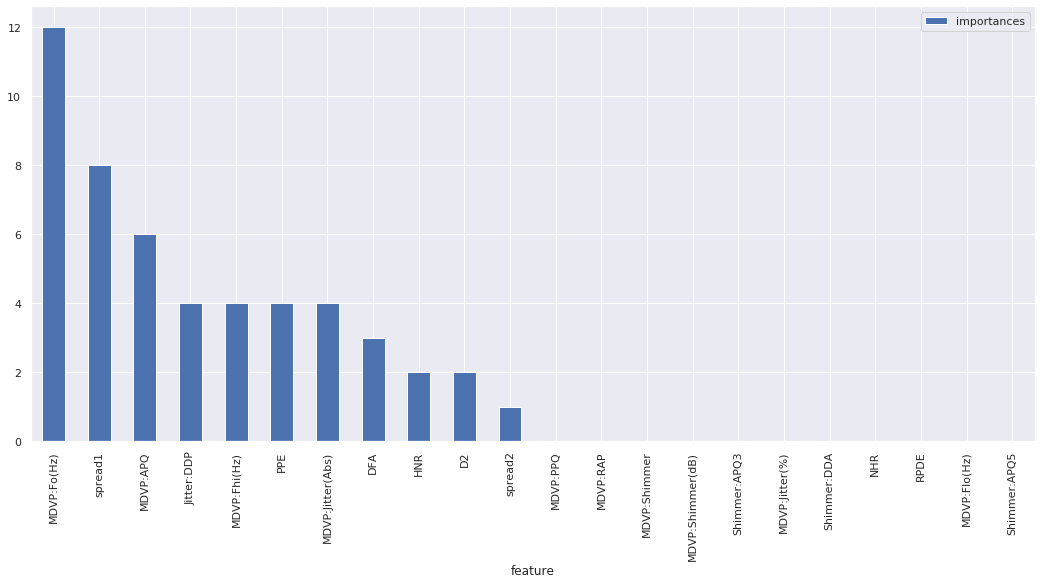

In [14]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('status', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### CatBoost

In [15]:
model = CatBoostClassifier(verbose=False)
param_grid = {
    'learning_rate': [0.1, 0.16, 0.2],
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.monotonic()
grid_search.fit(X_train, y_train)
total_time = round((time.monotonic() - start_time), 2)
predict = grid_search.predict(X_test)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')
    
quality.loc['CatBoost', :] = get_classification_metrics(y_test, predict) + [total_time]
quality

Best params:
===
learning_rate: 0.2
max_depth: 3
n_estimators: 200


,Accuracy,Precision,Recall,F1 score,Roc_auc,"Time, sec"
XGBoost,0.864,0.909,0.909,0.909,0.821,2.79
LightGBM,0.864,0.846,1.000,0.917,0.733,1.23
CatBoost,0.915,0.915,0.977,0.945,0.855,21.69


#### Важность признаков

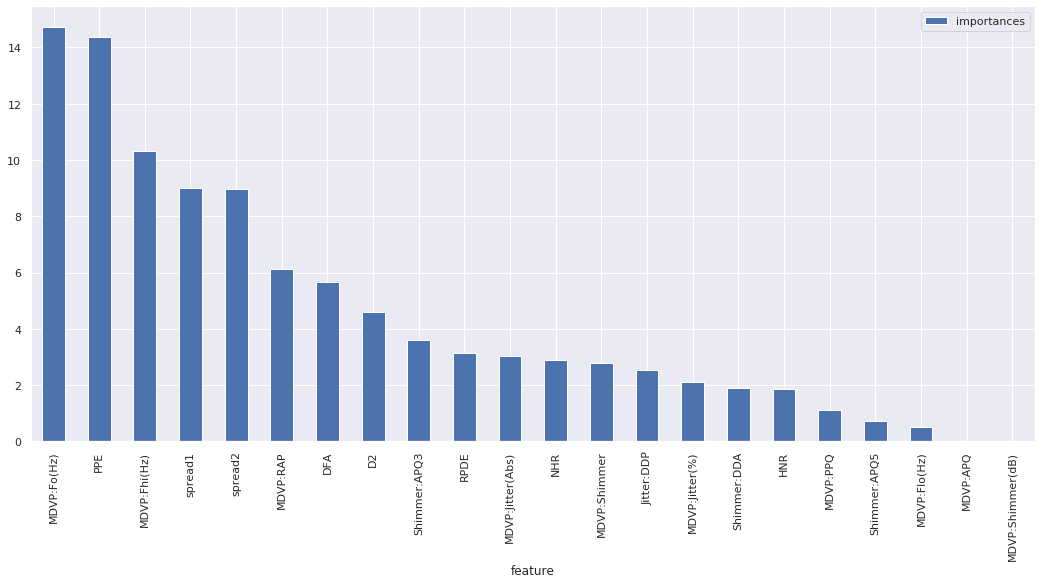

In [16]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('status', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### AdaBoostClassifier

In [17]:
model = AdaBoostClassifier()
param_grid = {
    'learning_rate': [0.1, 0.16, 0.2],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [50, 100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1)
start_time = time.monotonic()
grid_search.fit(X_train, y_train)
total_time = round((time.monotonic() - start_time), 2)
predict = grid_search.predict(X_test)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')
    
quality.loc['AdaBoost', :] = get_classification_metrics(y_test, predict) + [total_time]
quality

Best params:
===
algorithm: SAMME.R
learning_rate: 0.16
n_estimators: 200


,Accuracy,Precision,Recall,F1 score,Roc_auc,"Time, sec"
XGBoost,0.864,0.909,0.909,0.909,0.821,2.79
LightGBM,0.864,0.846,1.000,0.917,0.733,1.23
CatBoost,0.915,0.915,0.977,0.945,0.855,21.69
AdaBoost,0.864,0.860,0.977,0.915,0.755,12.75


#### Важность признаков

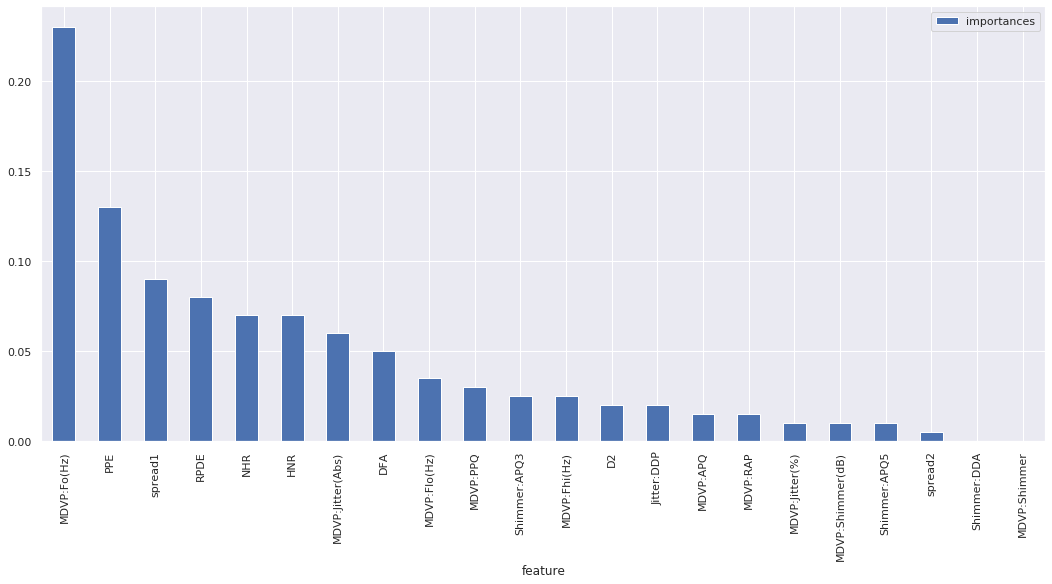

In [18]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('status', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### Итоговые метрики

In [19]:
quality.sort_values(['Roc_auc'], ascending=False)

,Accuracy,Precision,Recall,F1 score,Roc_auc,"Time, sec"
CatBoost,0.915,0.915,0.977,0.945,0.855,21.69
XGBoost,0.864,0.909,0.909,0.909,0.821,2.79
AdaBoost,0.864,0.860,0.977,0.915,0.755,12.75
LightGBM,0.864,0.846,1.000,0.917,0.733,1.23
